## Google drive mount
- google colab 사용 시, google drive 내 데이터를 사용하기 위한 절차입니다

In [ ]:
# google drive에 있는 데이터를 사용하기 위해 접근

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Library import 및 그래프 설정

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, f1_score, accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

#주피터 노트북 안에서 그래프를 그리기 위해 선언
%matplotlib inline

#그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 사용
plt.style.use('ggplot')

#그래프에서 마이너스 폰트 깨지는 것 대처
mpl.rcParams['axes.unicode_minus'] = False

## 데이터 추출
- Class label은 train set에만 있으므로 train set만 활용

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/숨고/최성우님(캐글 과제)/data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

- 데이터에 중복이 존재한다면 제거합니다

In [ ]:
train = train.drop_duplicates(keep='first').reset_index(drop=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

- 수치형/범주형/Label 컬럼명 분리

In [ ]:
numeric_columns = ['Popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                   'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_in min/ms', 'time_signature']
cate_columns = ['Artist Name', 'Track Name']
label_columns = ['Class']

- 빠른 학습을 위해 Text 변수인 Artist Name, Track Name은 제외하고 학습하기로 함

## EDA

In [ ]:
# 변수들의 기초 통계량 파악
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Popularity,17568.0,44.512124,17.426928,1.000000,33.000000,44.00000,56.00000,100.000
danceability,17996.0,0.543433,0.166268,0.059600,0.432000,0.54500,0.65900,0.989
energy,17996.0,0.662777,0.235373,0.000020,0.509000,0.70000,0.86000,1.000
key,15982.0,5.952447,3.196854,1.000000,3.000000,6.00000,9.00000,11.000
loudness,17996.0,-7.910660,4.049151,-39.952000,-9.538000,-7.01600,-5.18900,1.355
mode,17996.0,0.636753,0.480949,0.000000,0.000000,1.00000,1.00000,1.000
speechiness,17996.0,0.079707,0.083576,0.022500,0.034800,0.04740,0.08300,0.955
acousticness,17996.0,0.247082,0.310632,0.000000,0.004300,0.08140,0.43400,0.996
instrumentalness,13619.0,0.177562,0.304048,0.000001,0.000089,0.00391,0.20000,0.996
liveness,17996.0,0.196170,0.159212,0.011900,0.097500,0.12900,0.25800,1.000


- 수치형 변수들에 대해 결측값이 존재함
- 수치형 변수들에 대한 결측값 확인 및 대체(다중 대치법)

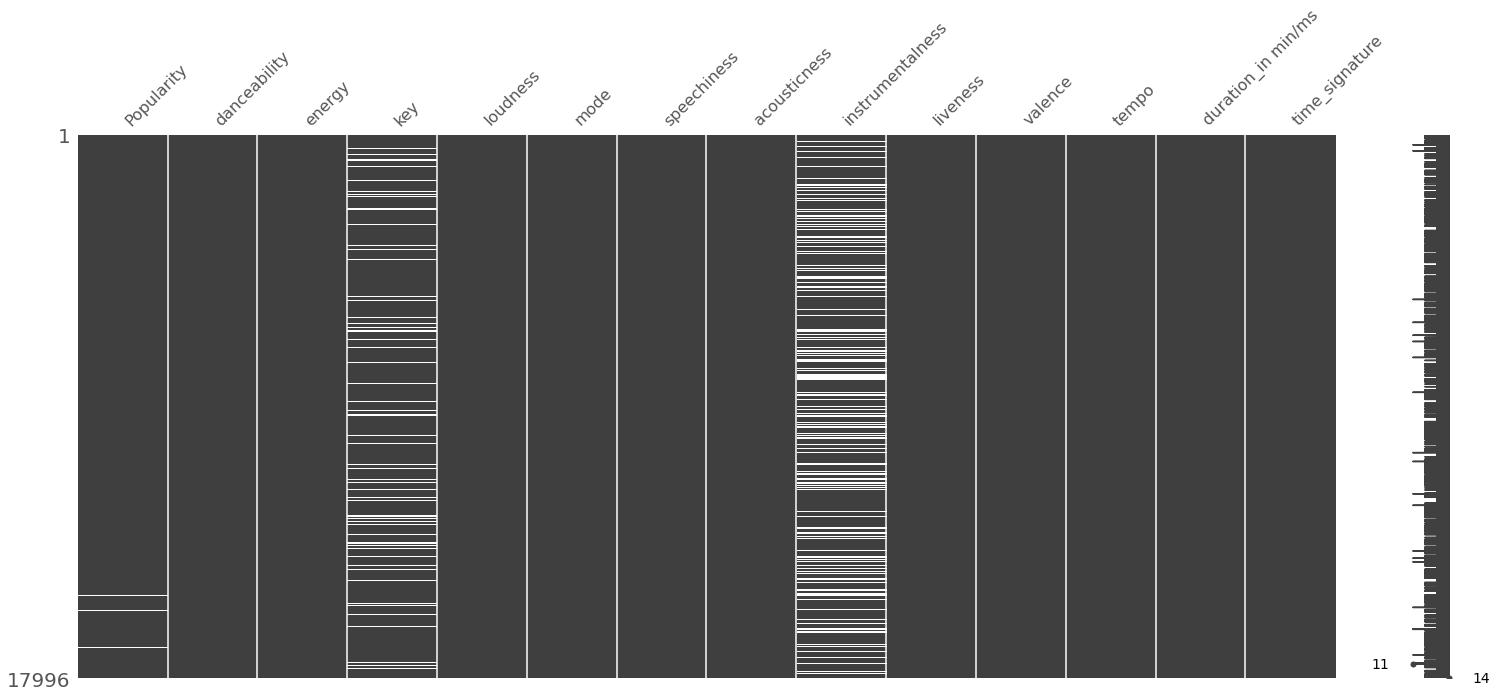

In [ ]:
msno.matrix(train[numeric_columns])

- class 변수에 대한 분포 확인(학습에 악영향을 미칠 수 있는 Imbalanced 한 분포를 지님)

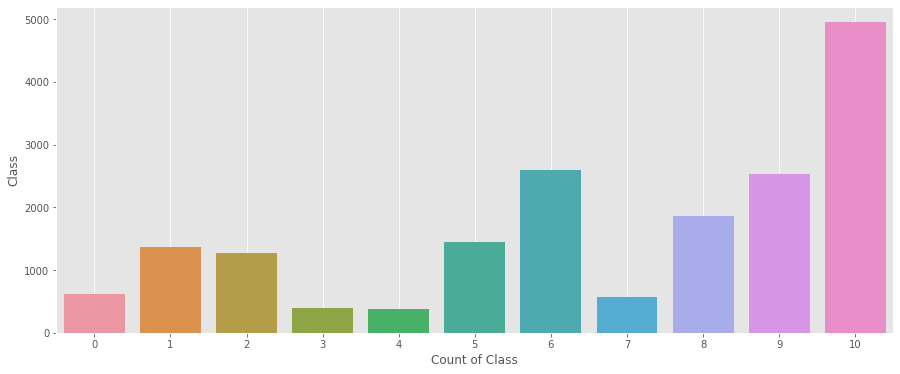

In [ ]:
# genre(class)의 count에 대한 분포
plt.figure(figsize=(15,6))
sns.countplot(x=train['Class'])
plt.ylabel('Class')
plt.xlabel('Count of Class')
plt.grid()
plt.show()

- 일부 변수들 간 의미있는 상관관계 확인

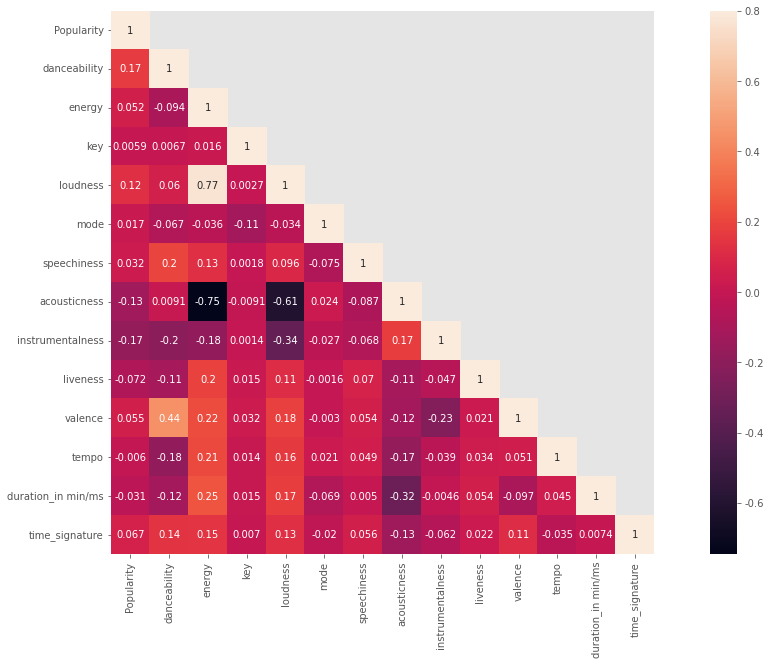

In [ ]:
# numeric 변수들간 상관관계 파악
corr = train[numeric_columns].corr()

mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corr, mask=mask,vmax=.8, square=True,annot=True)

- 독립변수의 분포 확인

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b4c4002d0>,
      dtype=object)

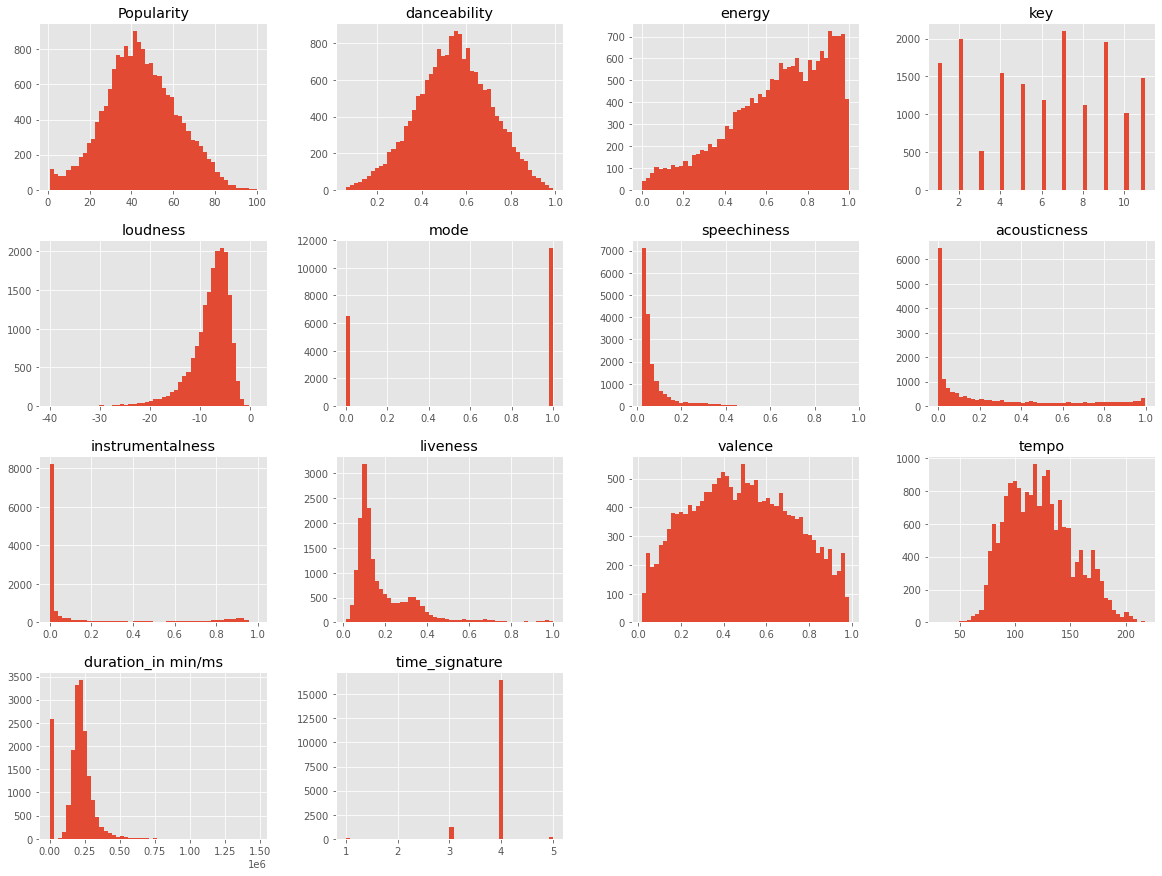

In [ ]:
train[numeric_columns].hist(bins=50, figsize=(20,15))

- 결측치 보간(다중 대치법)

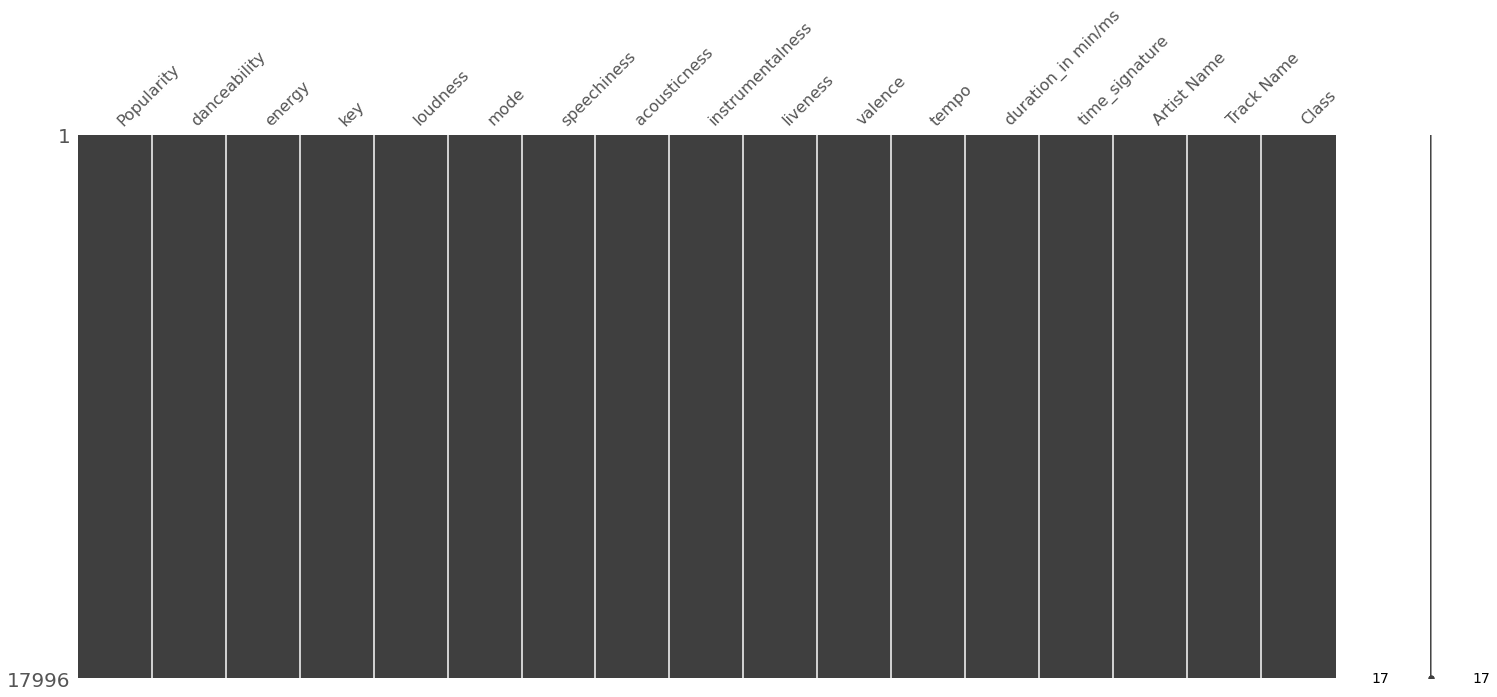

In [ ]:
# 다중대치법을 통한 수치형 변수 결측치 보간
imp_algorithm = IterativeImputer(random_state=20221003)
imp_data = imp_algorithm.fit_transform(train[numeric_columns])
imp_data = pd.DataFrame(imp_data, columns=numeric_columns)
train = pd.concat([imp_data, train[cate_columns+label_columns]],axis=1)
msno.matrix(train)

- 카테고리컬 변수 제거

In [ ]:
train = train.drop(cate_columns, axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Popularity          17996 non-null  float64
 1   danceability        17996 non-null  float64
 2   energy              17996 non-null  float64
 3   key                 17996 non-null  float64
 4   loudness            17996 non-null  float64
 5   mode                17996 non-null  float64
 6   speechiness         17996 non-null  float64
 7   acousticness        17996 non-null  float64
 8   instrumentalness    17996 non-null  float64
 9   liveness            17996 non-null  float64
 10  valence             17996 non-null  float64
 11  tempo               17996 non-null  float64
 12  duration_in min/ms  17996 non-null  float64
 13  time_signature      17996 non-null  float64
 14  Class               17996 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 2.1 MB


## Train/Test split

* Train:Test = 8:2 비율로 분리

In [ ]:
# train/validation/test split
x_train, x_test, y_train, y_test = train_test_split(train[numeric_columns], train[label_columns], test_size=0.2, random_state=20221003, stratify=train[label_columns])

- Train set에 대한 scaling(Test set에도 적용)

In [ ]:
mm = MinMaxScaler()
mm_train_data = mm.fit_transform(x_train)
mm_train_data = pd.DataFrame(mm_train_data, columns = numeric_columns,index=x_train.index)

mm_test_data = mm.transform(x_test)
mm_test_data = pd.DataFrame(mm_test_data, columns = numeric_columns,index=x_test.index)

- label변수 one hot encoding

In [ ]:
onehot = OneHotEncoder(sparse=False)
train_class = onehot.fit_transform(y_train.values.reshape(-1,1))
test_class = onehot.transform(y_test.values.reshape(-1,1))

## Modeling

- randomforest, light gradient boosting, extreme gradient boosting 비교
- gridsearch를 활용한 최적 모델 검출

In [ ]:
# randomforest
rf_model= RandomForestClassifier(random_state=20221003, n_jobs=-1)
param_grid = { 
    'n_estimators': [50,100,300,500,1000]
}
rf_grid = GridSearchCV(estimator=rf_model, param_grid=param_grid, n_jobs=-1, verbose=3)
rf_multi_grid = MultiOutputClassifier(rf_grid, n_jobs=-1)
rf_multi_grid.fit(mm_train_data, train_class)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


MultiOutputClassifier(estimator=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1,
                                                                              random_state=20221003),
                                             n_jobs=-1,
                                             param_grid={'n_estimators': [50,
                                                                          100,
                                                                          300,
                                                                          500,
                                                                          1000]},
                                             verbose=3),
                      n_jobs=-1)

In [ ]:
# lgbm
lgbm_model = lgb.LGBMClassifier(random_state=20221003,n_jobs=-1,verbose=3)
param_grid = {'learning_rate':[0.05,0.1,0.2]}

lgbm_grid = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, n_jobs=-1)
lgbm_multi_grid = MultiOutputClassifier(lgbm_grid, n_jobs=-1)
lgbm_multi_grid.fit(mm_train_data, train_class)

MultiOutputClassifier(estimator=GridSearchCV(estimator=LGBMClassifier(random_state=20221003,
                                                                      verbose=3),
                                             n_jobs=-1,
                                             param_grid={'learning_rate': [0.05,
                                                                           0.1,
                                                                           0.2]}),
                      n_jobs=-1)

In [ ]:
# xgb
xgb_model = XGBClassifier(random_state=20221003, n_jobs=-1,verbose=3)
param_grid = {'n_estimators' : [100,300,500],'learning_rate' : [0.01,0.1]}

xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv= 5, n_jobs=-1)
xgb_multi_grid = MultiOutputClassifier(xgb_grid, n_jobs=-1)
xgb_multi_grid.fit(mm_train_data, train_class)

MultiOutputClassifier(estimator=GridSearchCV(cv=5,
                                             estimator=XGBClassifier(n_jobs=-1,
                                                                     random_state=20221003,
                                                                     verbose=3),
                                             n_jobs=-1,
                                             param_grid={'learning_rate': [0.01,
                                                                           0.1],
                                                         'n_estimators': [100,
                                                                          300,
                                                                          500]}),
                      n_jobs=-1)

## Evaluation

In [ ]:
 # RF Metrics for confusion matrix
y_rf_pred = pd.DataFrame(rf_multi_grid.predict(mm_test_data))
print(classification_report(test_class, y_rf_pred))
print("Accuracy score :", round(accuracy_score(test_class, y_rf_pred),2))
print("F1 score :", round(f1_score(test_class, y_rf_pred, average='micro'),2))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


              precision    recall  f1-score   support

           0       0.84      0.46      0.59       125
           1       0.02      0.01      0.01       275
           2       0.54      0.12      0.19       254
           3       0.96      0.61      0.75        80
           4       0.76      0.36      0.49        77
           5       0.76      0.60      0.67       290
           6       0.24      0.08      0.11       518
           7       0.98      0.86      0.92       115
           8       0.66      0.43      0.52       371
           9       0.59      0.24      0.34       505
          10       0.48      0.27      0.35       990

   micro avg       0.56      0.29      0.38      3600
   macro avg       0.62      0.37      0.45      3600
weighted avg       0.52      0.29      0.36      3600
 samples avg       0.28      0.29      0.28      3600

Accuracy score : 0.28
F1 score : 0.38


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
 # lgbm Metrics for confusion matrix
y_lgbm_pred = pd.DataFrame(lgbm_multi_grid.predict(mm_test_data))
print(classification_report(test_class, y_lgbm_pred))
print("Accuracy score :", round(accuracy_score(test_class, y_lgbm_pred),2))
print("F1 score :", round(f1_score(test_class, y_lgbm_pred, average='micro'),2))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64       125
           1       0.50      0.02      0.04       275
           2       0.65      0.20      0.31       254
           3       0.86      0.75      0.80        80
           4       0.70      0.48      0.57        77
           5       0.75      0.66      0.70       290
           6       0.66      0.07      0.13       518
           7       0.97      0.92      0.95       115
           8       0.71      0.47      0.56       371
           9       0.72      0.34      0.47       505
          10       0.58      0.30      0.40       990

   micro avg       0.70      0.34      0.45      3600
   macro avg       0.71      0.44      0.51      3600
weighted avg       0.66      0.34      0.41      3600
 samples avg       0.33      0.34      0.33      3600

Accuracy score : 0.32
F1 score : 0.45


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
 # xgb Metrics for confusion matrix
y_xgb_pred = pd.DataFrame(xgb_multi_grid.predict(mm_test_data))
print(classification_report(test_class, y_xgb_pred))
print("Accuracy score :", round(accuracy_score(test_class, y_xgb_pred),2))
print("F1 score :", round(f1_score(test_class, y_xgb_pred, average='micro'),2))

              precision    recall  f1-score   support

           0       0.78      0.61      0.68       125
           1       0.56      0.02      0.04       275
           2       0.67      0.22      0.33       254
           3       0.86      0.74      0.79        80
           4       0.74      0.56      0.64        77
           5       0.75      0.67      0.71       290
           6       0.53      0.09      0.16       518
           7       0.96      0.90      0.93       115
           8       0.70      0.46      0.56       371
           9       0.71      0.30      0.42       505
          10       0.55      0.31      0.40       990

   micro avg       0.68      0.34      0.45      3600
   macro avg       0.71      0.44      0.51      3600
weighted avg       0.64      0.34      0.42      3600
 samples avg       0.33      0.34      0.33      3600

Accuracy score : 0.33
F1 score : 0.45


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
